# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')


In [2]:
import pickle
from simulation import MultiTODSimulation
# Load the simulation data from a pickle file
with open('multi_tod_simulation_data.pkl', 'rb') as f:
    multi_tod_sim = pickle.load(f)

In [3]:
# Make all the individual variables available for backward compatibility
t_list = multi_tod_sim.t_list
theta_c_setting = multi_tod_sim.theta_c_setting
phi_c_setting = multi_tod_sim.phi_c_setting
theta_c_rising = multi_tod_sim.theta_c_rising
phi_c_rising = multi_tod_sim.phi_c_rising
bool_map_setting = multi_tod_sim.bool_map_setting
bool_map_rising = multi_tod_sim.bool_map_rising
integrated_beam_setting = multi_tod_sim.integrated_beam_setting
integrated_beam_rising = multi_tod_sim.integrated_beam_rising
full_bool_map = multi_tod_sim.full_bool_map
pixel_indices = multi_tod_sim.pixel_indices
integrated_beam = multi_tod_sim.integrated_beam
Tsky_operator_setting = multi_tod_sim.Tsky_operator_setting
Tsky_operator_rising = multi_tod_sim.Tsky_operator_rising
sky_params = multi_tod_sim.sky_params
ntime = multi_tod_sim.ntime
ndiode_proj = multi_tod_sim.ndiode_proj
nd_rec_operator = multi_tod_sim.nd_rec_operator
nd_rec_params = multi_tod_sim.nd_rec_params
gain_proj = multi_tod_sim.gain_proj
gain_params_setting = multi_tod_sim.gain_params_setting
gain_params_rising = multi_tod_sim.gain_params_rising
gains_setting = multi_tod_sim.gains_setting
gains_rising = multi_tod_sim.gains_rising
fc = multi_tod_sim.fc
logfc = multi_tod_sim.logfc
f0 = multi_tod_sim.f0
logf0 = multi_tod_sim.logf0
noise_setting = multi_tod_sim.noise_setting
noise_rising = multi_tod_sim.noise_rising
Tsys_setting = multi_tod_sim.Tsys_setting
Tsys_rising = multi_tod_sim.Tsys_rising
TOD_setting = multi_tod_sim.TOD_setting
TOD_rising = multi_tod_sim.TOD_rising
pixels_c_setting = multi_tod_sim.pixels_c_setting
bool_map_c_setting = multi_tod_sim.bool_map_c_setting
calibration_1_index = multi_tod_sim.calibration_1_index
calibration_5_indices = multi_tod_sim.calibration_5_indices

# Additional constants from the original code
T_ndiode = multi_tod_sim.T_ndiode
rec_params = multi_tod_sim.rec_params
dtime = multi_tod_sim.dtime
alpha = multi_tod_sim.alpha
logf0_list = [multi_tod_sim.logf0]
sigma_2 = multi_tod_sim.sigma_2

In [ ]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params, nd_rec_params])
init_noise_params = [logf0, alpha]


init_Tloc_params_list = [nd_rec_params, nd_rec_params]
init_Tsky_params = sky_params
init_noise_params_list = [init_noise_params, init_noise_params]

prior_std_frac = 0.1

# gain_prior_mean = gain_params_setting
# gain_prior_cov_inv = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
# gain_prior_cov_inv[gain_prior_cov_inv > 100] = 100

Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
calibration_indices = calibration_5_indices
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = 1.0 / (nd_rec_params)**2  # Prior STD ~100%
aux[0] = 10.0
aux[1] = 1.0
Trec_prior_cov_inv_list = [aux, aux]

def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - alpha)**4 

In [ ]:
log_gain_setting = np.log(gain_proj@gain_params_setting)
# solve the linear system for the log_gain coeffs: gain_proj@ log_gain_coeffs = log_gain
log_gain_setting_coeffs = np.linalg.lstsq(gain_proj, log_gain_setting, rcond=None)[0]
gain_prior_mean_setting = log_gain_setting_coeffs

print("log_gain_coeffs:", log_gain_setting_coeffs)

log_gain_rising = np.log(gain_proj@gain_params_rising)
# solve the linear system for the log_gain coeffs: gain_proj@ log_gain_coeffs = log_gain
log_gain_rising_coeffs = np.linalg.lstsq(gain_proj, log_gain_rising, rcond=None)[0]
gain_prior_mean_rising = log_gain_rising_coeffs

print("log_gain_coeffs:", log_gain_rising_coeffs)

gain_prior_cov_inv_setting = 1.0 / (prior_std_frac * gain_params_setting)**2  # Prior STD ~10%
gain_prior_cov_inv_setting[gain_prior_cov_inv_setting > 100] = 100
gain_prior_cov_inv_rising = 1.0 / (prior_std_frac * gain_params_rising)**2  # Prior STD ~10%
gain_prior_cov_inv_rising[gain_prior_cov_inv_rising > 100] = 100

In [ ]:
# Import the FlickerCorrEmulator class first
from full_Gibbs_sampler import TOD_Gibbs_sampler

Tsys_samples, all_gain_samples, all_noise_samples = \
    TOD_Gibbs_sampler(
        [TOD_setting, TOD_rising],
        [t_list, t_list],
        [gain_proj, gain_proj],
        [Tsky_operator_setting, Tsky_operator_rising],
        [nd_rec_operator, nd_rec_operator],
        init_Tsky_params,
        init_Tloc_params_list,
        init_noise_params_list,
        [logfc, logfc],
        wnoise_var=2.5e-6,
        Tsky_prior_cov_inv=Tsky_prior_cov_inv,
        Tsky_prior_mean=sky_params,
        local_Tloc_prior_cov_inv_list=Trec_prior_cov_inv_list,
        local_Tloc_prior_mean_list=[nd_rec_params, nd_rec_params],
        local_gain_prior_cov_inv_list=[gain_prior_cov_inv_setting, gain_prior_cov_inv_rising],
        local_gain_prior_mean_list=[gain_prior_mean_setting, gain_prior_mean_rising],
        local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
        joint_Tsys_sampling=True,
        smooth_gain_model="log",
        noise_sampler_type="emcee",
        noise_Jeffreys_prior=False,
        n_samples=2000,
        tol=1e-20)

In [ ]:
# First, save the samples as npy files..

np.save("outputs/GSF5_db/Tsys_samples_logG.npy", Tsys_samples)
np.save("outputs/GSF5_db/gain_samples_logG.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GSF5_db/noise_samples_logG.npy", np.concatenate(all_noise_samples, axis=0))

# np.save("outputs/GSF5_db/Tsky_samples_logG.npy", Tsky_samples)
# np.save("outputs/GSF5_db/gain_samples_logG.npy", np.concatenate(all_gain_samples, axis=0))
# np.save("outputs/GSF5_db/noise_samples_logG.npy", np.concatenate(all_noise_samples, axis=0))
# np.save("outputs/GSF5_db/Tloc_samples_logG.npy", np.concatenate(all_Tloc_samples, axis=0))

In [4]:
Tsys_samples = np.load("outputs/GSF5_db/Tsys_samples_logG.npy")
gain_samples = np.load("outputs/GSF5_db/gain_samples_logG.npy")
noise_samples = np.load("outputs/GSF5_db/noise_samples_logG.npy")


In [5]:
from MCMC_diagnostics import diagnostics

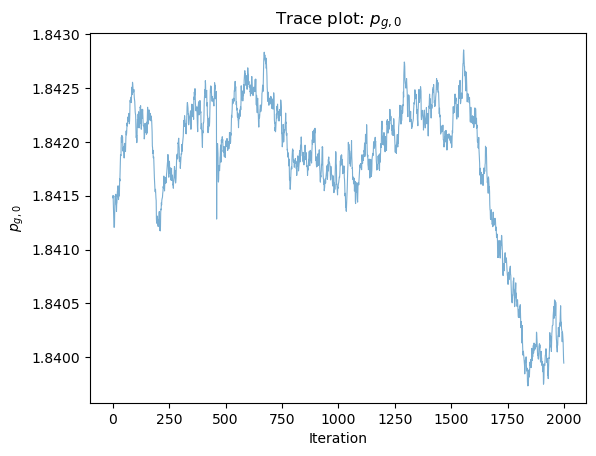

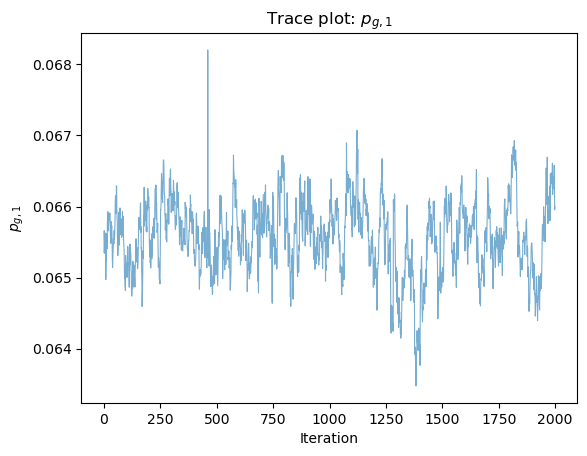

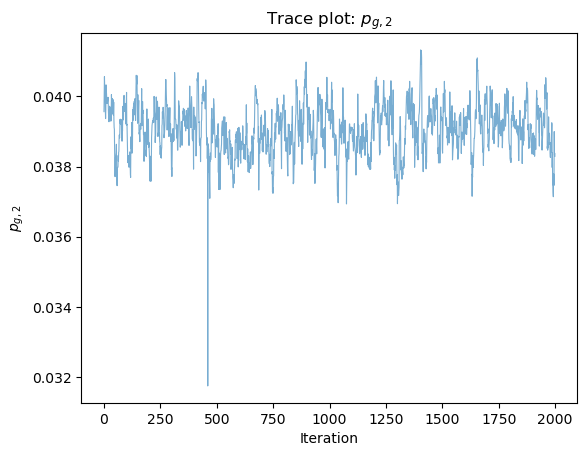

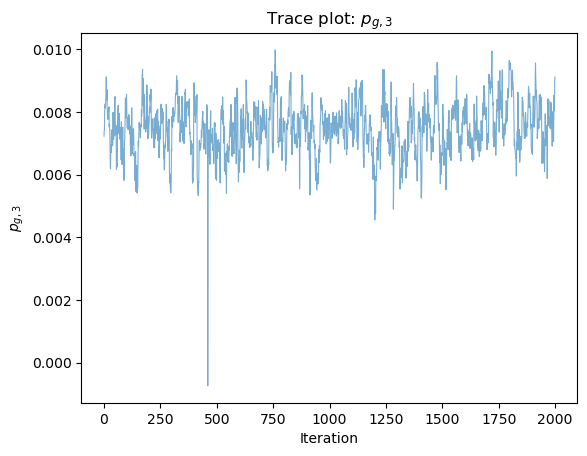

{'$p_{g,0}$': {'ESS_min': 7.16224979020033,
  'ESS_median': 7.16224979020033,
  'Rhat_split': 1.1437638005210906},
 '$p_{g,1}$': {'ESS_min': 52.366713764375746,
  'ESS_median': 52.366713764375746,
  'Rhat_split': 1.0107608261371344},
 '$p_{g,2}$': {'ESS_min': 180.22052222666628,
  'ESS_median': 180.22052222666628,
  'Rhat_split': 1.0018655090215853},
 '$p_{g,3}$': {'ESS_min': 179.2973045807396,
  'ESS_median': 179.2973045807396,
  'Rhat_split': 1.0052309278212281}}

In [6]:
aux = gain_samples[0].reshape(1, -1, 4)
diagnostics(aux, param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"], max_plots=5)

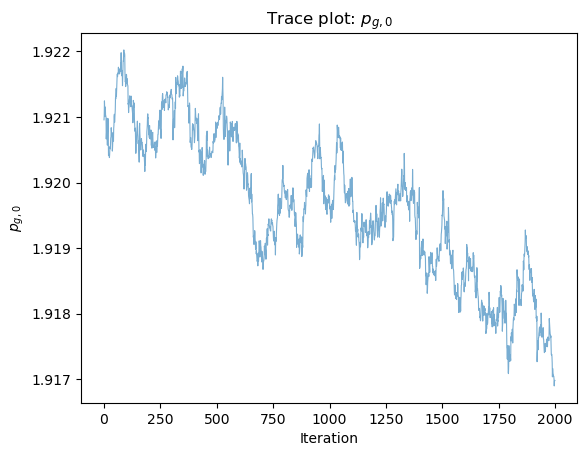

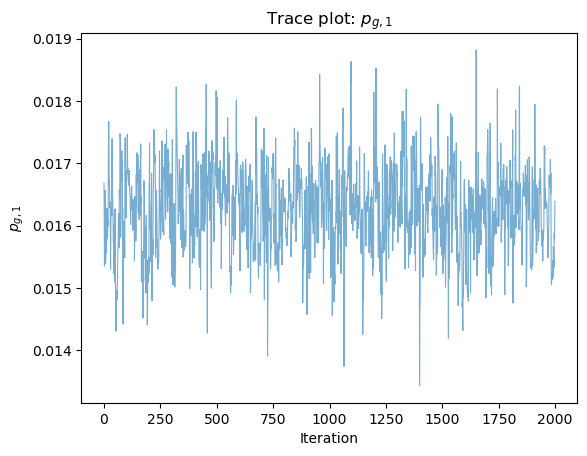

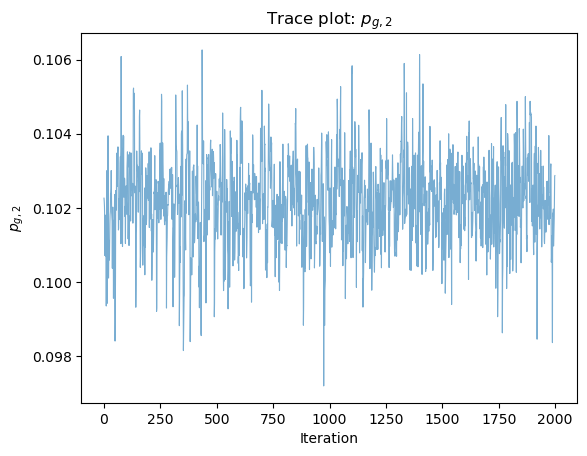

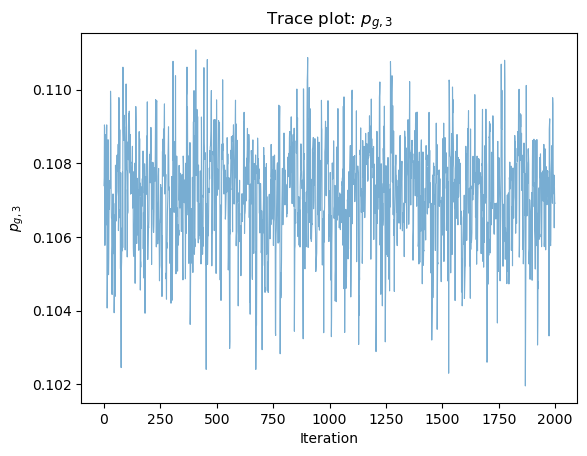

{'$p_{g,0}$': {'ESS_min': 3.6767527972421408,
  'ESS_median': 3.6767527972421408,
  'Rhat_split': 1.7040667622078942},
 '$p_{g,1}$': {'ESS_min': 365.0872354455019,
  'ESS_median': 365.0872354455019,
  'Rhat_split': 1.0013192740155585},
 '$p_{g,2}$': {'ESS_min': 541.4515928119823,
  'ESS_median': 541.4515928119823,
  'Rhat_split': 1.0015066669593433},
 '$p_{g,3}$': {'ESS_min': 610.9736359408649,
  'ESS_median': 610.9736359408649,
  'Rhat_split': 0.9998630382989918}}

In [7]:
aux = gain_samples[1].reshape(1, -1, 4)
diagnostics(aux, param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"], max_plots=5)

292
All pixels - Mean: -0.0025, Std: 0.1768, RMS: 0.1768
All pixels - 16th-84th percentile: [-0.0417, 0.0679]
Internal pixels - Mean: -0.0023, Std: 0.1228, RMS: 0.1228
Internal pixels - 16th-84th percentile: [-0.0216, 0.0274]
Plot saved to: figures/new/GSF5_db_log_mean_res.pdf


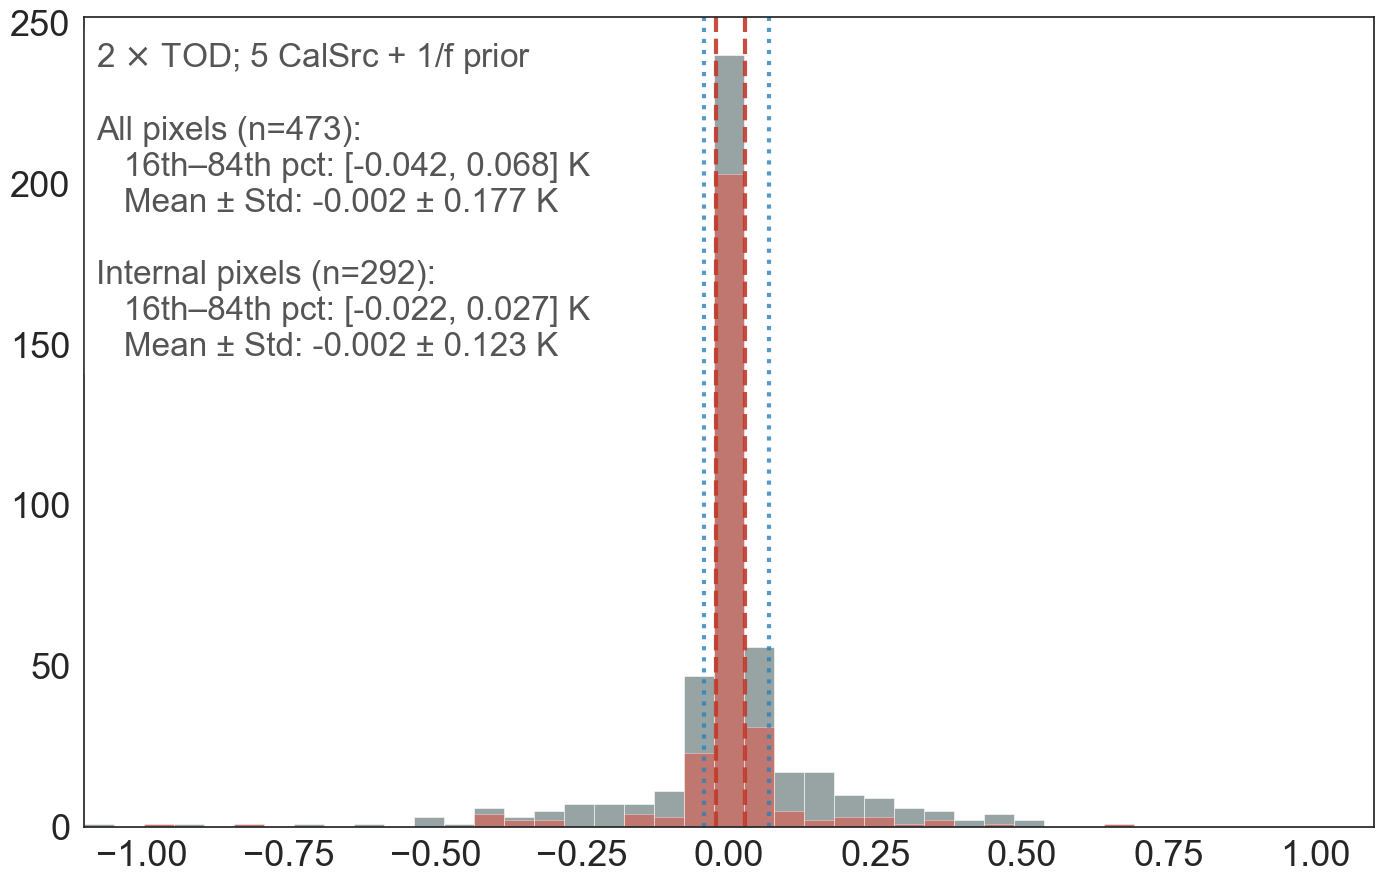

All pixels - Mean: -0.0026, Std: 0.1780, RMS: 0.1780
All pixels - 16th-84th percentile: [-0.0414, 0.0667]
Internal pixels - Mean: -0.0024, Std: 0.1226, RMS: 0.1227
Internal pixels - 16th-84th percentile: [-0.0217, 0.0276]
Plot saved to: figures/new/GSF5_db_log_median_res.pdf


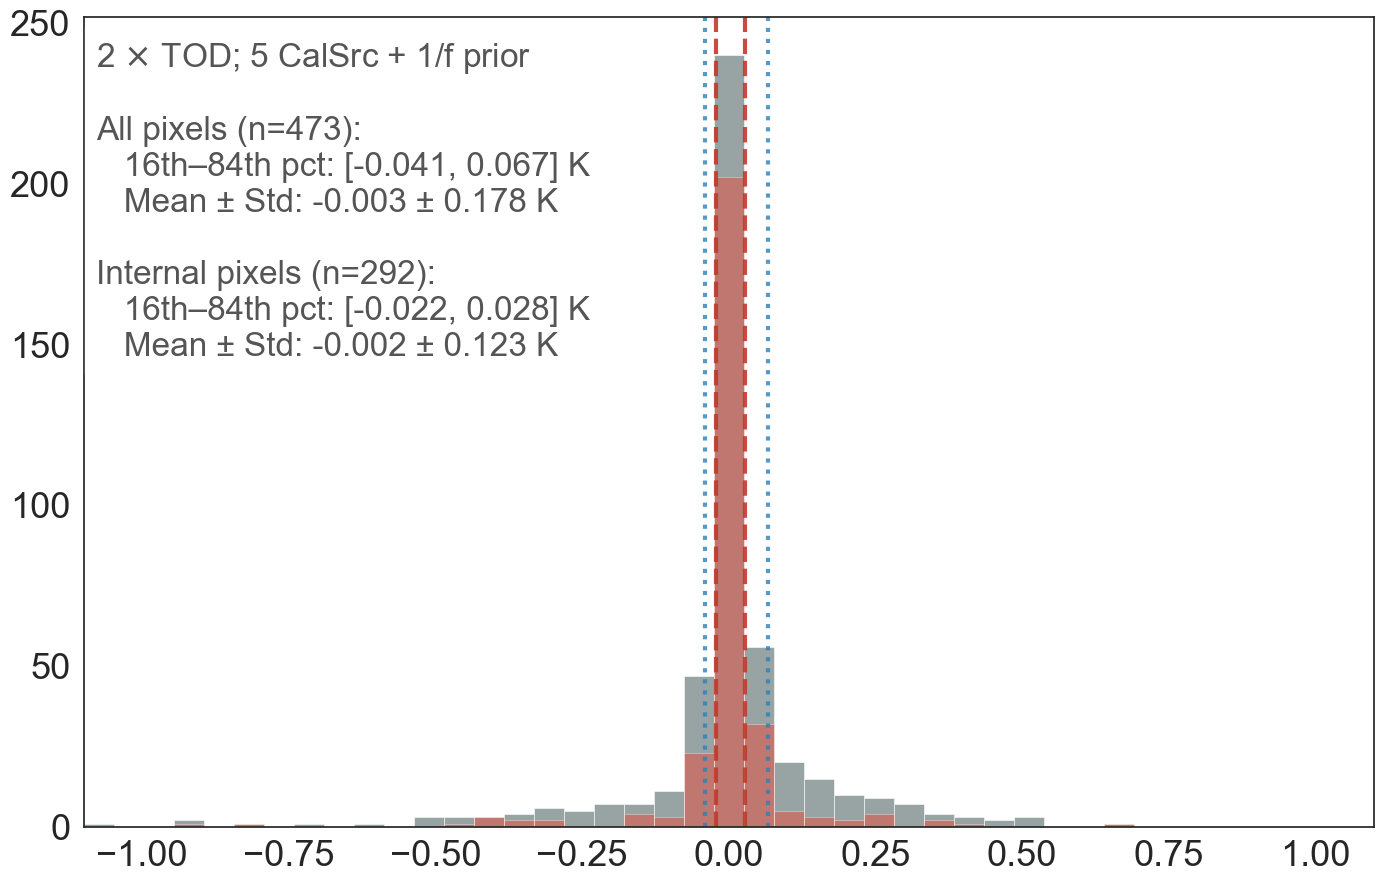

/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/zzhang/Workspace/flicker/test/../hydra_tod/visualisation.py:612: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be in

{'mean': (array([ 8.74595609,  8.6945686 ,  8.68518432,  8.36774768,  8.00877487,
          7.88413935,  7.49713755,  7.11989216,  7.780227  ,  6.76638974,
          8.65889848,  8.39310038,  9.08726608,  8.79415709,  9.16474662,
          8.10605332,  7.70549809,  8.65980617,  8.43037102,  8.2263647 ,
          8.30908757,  8.0262451 ,  8.44427371,  7.1562587 ,  7.34902876,
          7.09681197,  6.49221399,  7.49721819,  6.22346043,  6.00308471,
          6.12855981,  5.78848311,  5.11007803,  5.63948111,  5.55026512,
          5.63497656,  5.67314394,  8.55767108,  8.73157181,  8.67727877,
          8.54959353,  8.36240801,  8.97969328,  8.11385179,  7.89912177,
          7.81497617,  7.78074678,  8.04361032,  7.85610658,  7.64257242,
          6.90570692,  6.72931549,  7.02066509,  6.7821733 ,  6.46038416,
          6.20928581,  6.2022674 ,  6.10525063,  5.65322731,  5.88534276,
          5.58951334,  5.74586269,  6.06071929,  5.88013107,  8.67695947,
          9.28078453,  8.84664

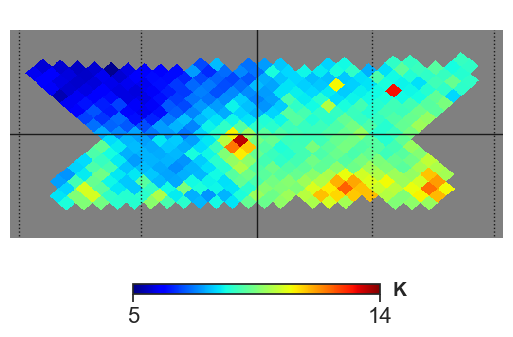

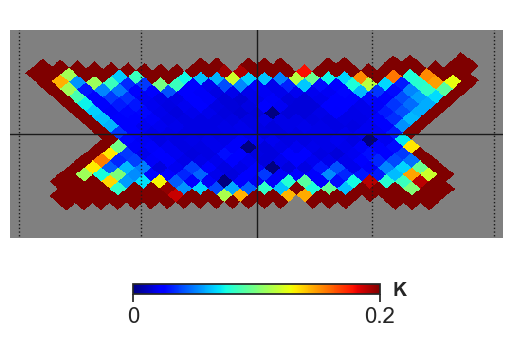

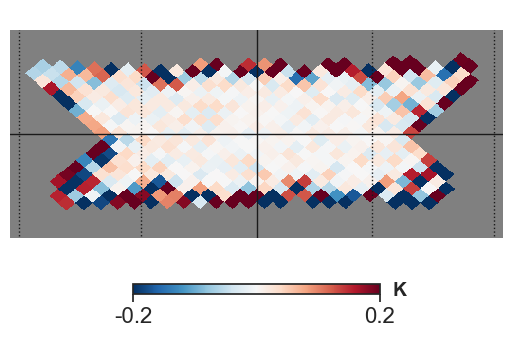

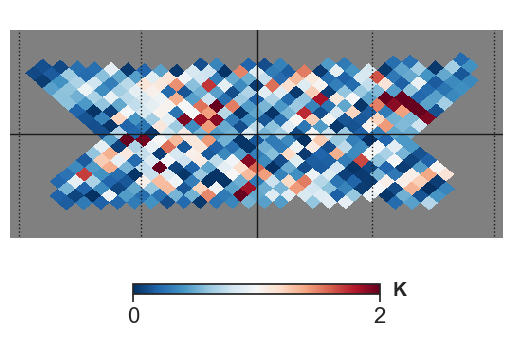

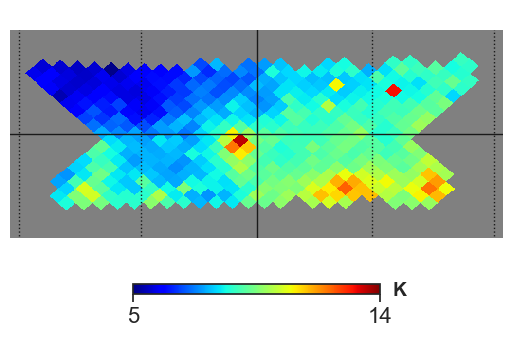

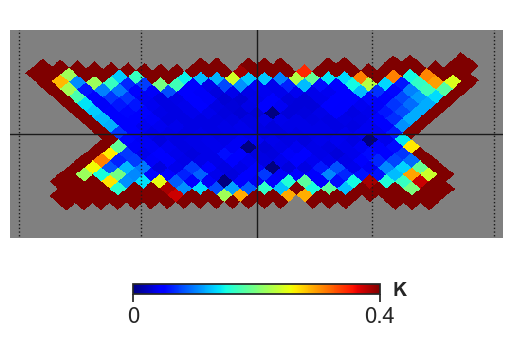

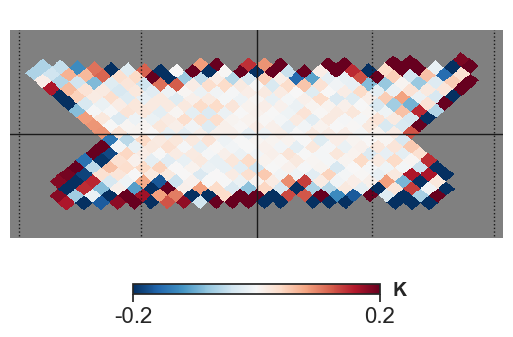

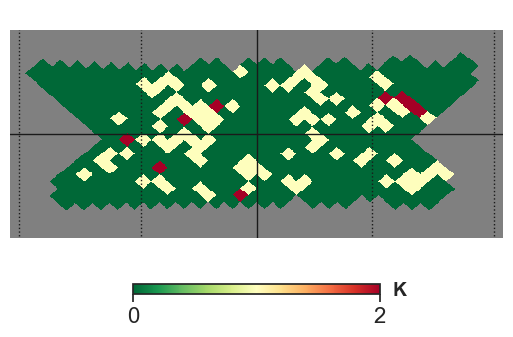

In [8]:
from simulation import TODSimulation, MultiTODSimulation
from analysis import explore_posterior_joint_Tsys
explore_posterior_joint_Tsys(Tsys_samples, 
                             gain_samples, 
                             noise_samples, 
                             sky_params,
                             title_str= r'2 $\times$ TOD; 5 CalSrc + 1/f prior',
                             save_path='figures/new/GSF5_db_log',
                             two_x_TODs=True, 
                             warm_up=0, 
                             cbar=True
                             )